In [3]:
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Project paths (edit BASE_DIR if your folder name differs)
# -----------------------------
BASE_DIR = "/content/drive/MyDrive/SkinAI_Project"

PROCESSED_DIR = os.path.join(BASE_DIR, "data", "processed")
MODELS_DIR    = os.path.join(BASE_DIR, "models")

REPORTS_DIR = os.path.join(BASE_DIR, "reports")
FIG_DIR     = os.path.join(REPORTS_DIR, "figures")
METRICS_DIR = os.path.join(REPORTS_DIR, "metrics")

# Create output folders if missing
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(METRICS_DIR, exist_ok=True)

print("BASE_DIR     :", BASE_DIR)
print("PROCESSED_DIR:", PROCESSED_DIR)
print("MODELS_DIR   :", MODELS_DIR)
print("FIG_DIR      :", FIG_DIR)
print("METRICS_DIR  :", METRICS_DIR)

print("\nProcessed files:")
print(os.listdir(PROCESSED_DIR))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
BASE_DIR     : /content/drive/MyDrive/SkinAI_Project
PROCESSED_DIR: /content/drive/MyDrive/SkinAI_Project/data/processed
MODELS_DIR   : /content/drive/MyDrive/SkinAI_Project/models
FIG_DIR      : /content/drive/MyDrive/SkinAI_Project/reports/figures
METRICS_DIR  : /content/drive/MyDrive/SkinAI_Project/reports/metrics

Processed files:
['text_augmented.csv', 'test_predictions.csv', 'structured', 'disease', 'unlabeled_text.csv', 'text_merged.csv', 'text_cleaned.csv', 'val.csv', 'text_cleaned_grouped6.csv', 'train.csv', 'text_cleaned_normalized.csv', 'dataset_health_report.csv', 'test.csv']


In [4]:
train_path = os.path.join(PROCESSED_DIR, "train.csv")
val_path   = os.path.join(PROCESSED_DIR, "val.csv")
test_path  = os.path.join(PROCESSED_DIR, "test.csv")

df_train = pd.read_csv(train_path)
df_val   = pd.read_csv(val_path)
df_test  = pd.read_csv(test_path)

print("Train shape:", df_train.shape)
print("Val shape  :", df_val.shape)
print("Test shape :", df_test.shape)

print("\nColumns:", df_train.columns.tolist())

# Basic checks
assert "text" in df_train.columns, "Missing 'text' column in train.csv"
assert "label" in df_train.columns, "Missing 'label' column in train.csv"

display(df_train.head())

print("\nLabel distribution (Train - top 25):")
print(df_train["label"].value_counts().head(25))

print("\nNumber of classes (Train):", df_train["label"].nunique())


Train shape: (7433, 3)
Val shape  : (1593, 3)
Test shape : (1593, 3)

Columns: ['text', 'label', 'source']


,text,label,source
0,"age: 68 | gender: male | symptom text: lately,...",Contact dermatitis (Irritant),synthetic/clinical_cases_10000.csv
1,age: 56 | gender: male | symptom text: recentl...,Tinea cruris (Jock itch),synthetic/clinical_cases_10000.csv
2,age: 48 | gender: male | symptom text: these d...,Cellulitis,synthetic/clinical_cases_10000.csv
3,age: 35 | gender: male | symptom text: i've no...,Seborrheic dermatitis,synthetic/clinical_cases_10000.csv
4,age: 48 | gender: female | symptom text: recen...,Impetigo,synthetic/clinical_cases_10000.csv



Label distribution (Train - top 25):
label
Tinea corporis (Ringworm)         275
Urticaria (Hives)                 269
Impetigo                          268
Seborrheic dermatitis             264
Dyshidrotic eczema                257
Herpes simplex (Cold sores)       253
Rosacea                           253
Pityriasis versicolor             252
Lichen planus                     248
Folliculitis                      248
Acne vulgaris                     248
Tinea capitis (Scalp ringworm)    246
Contact dermatitis (Irritant)     246
Perioral dermatitis               246
Tinea cruris (Jock itch)          245
Molluscum contagiosum             245
Chronic urticaria                 244
Vitiligo                          243
Nummular eczema                   242
Scabies                           239
Acne rosacea                      236
Cellulitis                        234
Psoriasis vulgaris                234
Contact dermatitis (Allergic)     231
Herpes zoster (Shingles)          230
Name: 

In [5]:
X_train = df_train["text"].astype(str).tolist()
y_train = df_train["label"].astype(str).tolist()

X_val = df_val["text"].astype(str).tolist()
y_val = df_val["label"].astype(str).tolist()

X_test = df_test["text"].astype(str).tolist()
y_test = df_test["label"].astype(str).tolist()

print("Example training texts:")
for i in range(min(3, len(X_train))):
    print(f"\n[{i}] label={y_train[i]}")
    print(X_train[i][:200], "...")


Example training texts:

[0] label=Contact dermatitis (Irritant)
age: 68 | gender: male | symptom text: lately, for around 6 months, i've had redness and itching on my hands/arms after using something new. it comes with stinging. it's not too severe. it comes and g ...

[1] label=Tinea cruris (Jock itch)
age: 56 | gender: male | symptom text: recently, for the last 5 weeks, i've had an itchy rash in the groin area. it comes with irritation. it's not too severe. it spreads a little when i scratch. trig ...

[2] label=Cellulitis
age: 48 | gender: male | symptom text: these days, for the last 7 weeks, i've had redness with swelling and warmth around a cut or scratch. it comes with tenderness. it's moderate. it stays in the sam ...


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

# ------------------------------------
# TF-IDF settings (keep consistent across models)
# ------------------------------------
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=5000,
    min_df=2,
    max_df=0.9
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf   = vectorizer.transform(X_val)
X_test_tfidf  = vectorizer.transform(X_test)

print("TF-IDF Shapes:")
print(" Train:", X_train_tfidf.shape)
print(" Val  :", X_val_tfidf.shape)
print(" Test :", X_test_tfidf.shape)


TF-IDF Shapes:
 Train: (7433, 4572)
 Val  : (1593, 4572)
 Test : (1593, 4572)


In [7]:
from sklearn.linear_model import LogisticRegression

# ------------------------------------
# Baseline model: TF-IDF + Logistic Regression
# - Multinomial: good for multi-class
# - class_weight='balanced': helps imbalanced diseases
# ------------------------------------
clf = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    max_iter=200,
    n_jobs=-1,
    class_weight="balanced"
)

print("Training Logistic Regression...")
clf.fit(X_train_tfidf, y_train)
print("Training finished ✅")


Training Logistic Regression...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training finished ✅


In [8]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

def evaluate_split(name, model, X, y_true):
    """
    Evaluates:
    - Accuracy
    - Macro-F1 (best for imbalanced multi-class)
    - Classification report
    Returns: (predictions, accuracy, macro_f1)
    """
    y_pred = model.predict(X)
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")
    print(f"\n=== {name} ===")
    print("Accuracy :", round(acc, 4))
    print("Macro-F1 :", round(f1m, 4))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, zero_division=0))
    return y_pred, acc, f1m

pred_train, acc_train, f1_train = evaluate_split("TRAIN", clf, X_train_tfidf, y_train)
pred_val,   acc_val,   f1_val   = evaluate_split("VALIDATION", clf, X_val_tfidf, y_val)
pred_test,  acc_test,  f1_test  = evaluate_split("TEST", clf, X_test_tfidf, y_test)

# Save test report to file
report_text = classification_report(y_test, pred_test, zero_division=0)
report_path = os.path.join(METRICS_DIR, "logreg_report.txt")
with open(report_path, "w", encoding="utf-8") as f:
    f.write(report_text)

print("\nSaved report:", report_path)



=== TRAIN ===
Accuracy : 0.7947
Macro-F1 : 0.8415

Classification Report:
                                precision    recall  f1-score   support

                          Acne       0.78      1.00      0.88        21
                  Acne rosacea       1.00      1.00      1.00       236
                 Acne vulgaris       1.00      0.99      1.00       248
             Actinic keratosis       0.93      1.00      0.96        25
    Athlete Foot (Tinea Pedis)       1.00      1.00      1.00         8
  Athlete's Foot (Tinea Pedis)       1.00      1.00      1.00         8
             Atopic Dermatitis       0.86      1.00      0.93        25
    Atopic dermatitis (Eczema)       0.29      0.32      0.30       228
              Benign keratosis       0.72      1.00      0.84        28
                    Cellulitis       1.00      1.00      1.00       234
             Chronic urticaria       1.00      1.00      1.00       244
            Contact Dermatitis       1.00      1.00      1.0

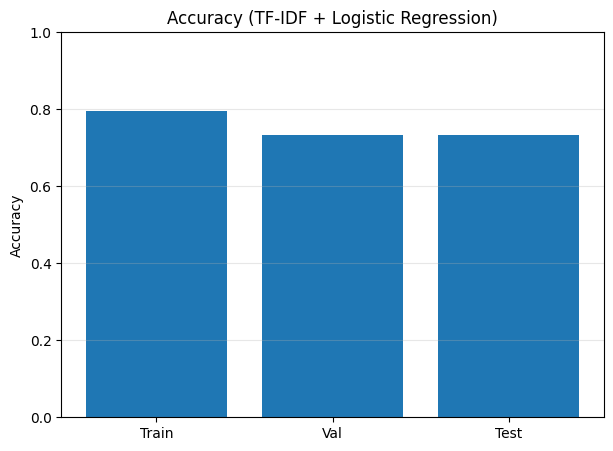

Saved: /content/drive/MyDrive/SkinAI_Project/reports/figures/logreg_accuracy_bar.png


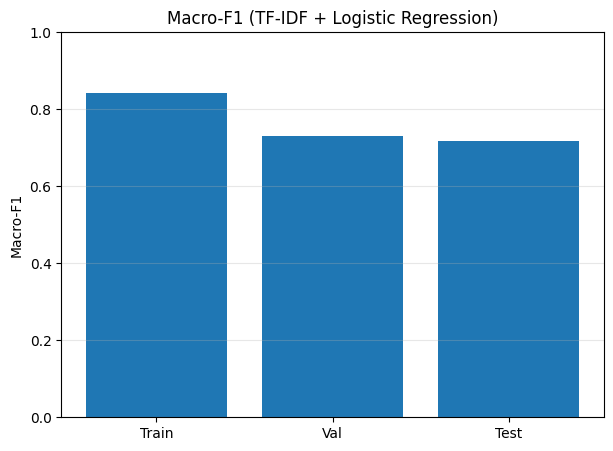

Saved: /content/drive/MyDrive/SkinAI_Project/reports/figures/logreg_macro_f1_bar.png


In [9]:
# Accuracy bar chart
plt.figure(figsize=(7,5))
plt.bar(["Train", "Val", "Test"], [acc_train, acc_val, acc_test])
plt.title("Accuracy (TF-IDF + Logistic Regression)")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True, axis="y", alpha=0.3)
acc_fig = os.path.join(FIG_DIR, "logreg_accuracy_bar.png")
plt.savefig(acc_fig, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", acc_fig)

# Macro-F1 bar chart
plt.figure(figsize=(7,5))
plt.bar(["Train", "Val", "Test"], [f1_train, f1_val, f1_test])
plt.title("Macro-F1 (TF-IDF + Logistic Regression)")
plt.ylabel("Macro-F1")
plt.ylim(0, 1)
plt.grid(True, axis="y", alpha=0.3)
f1_fig = os.path.join(FIG_DIR, "logreg_macro_f1_bar.png")
plt.savefig(f1_fig, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", f1_fig)


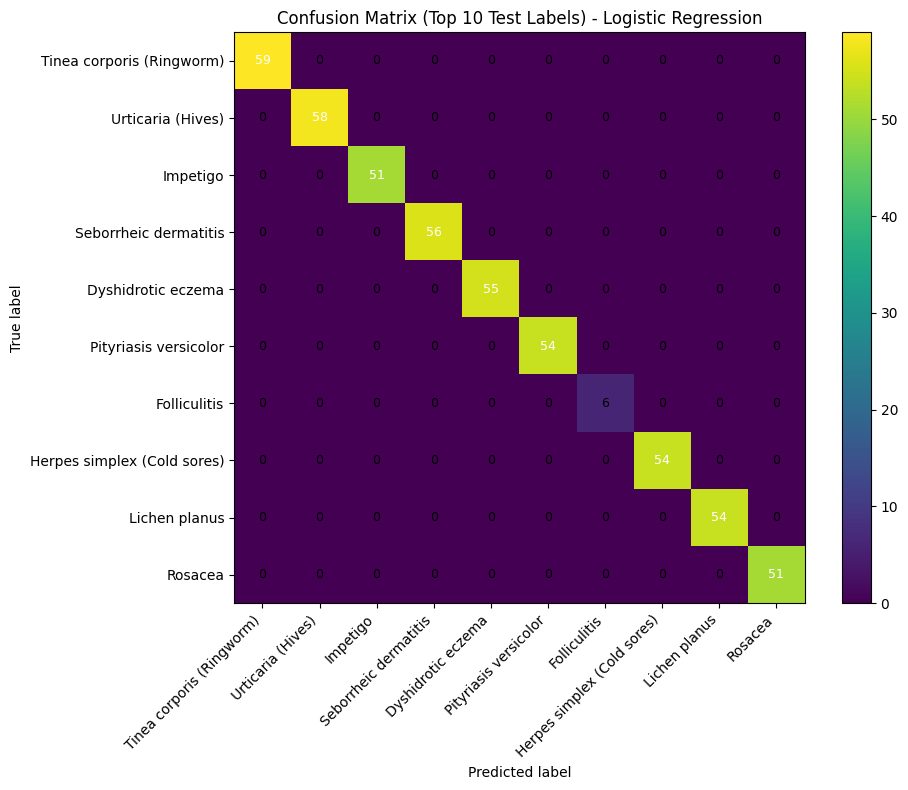

Saved: /content/drive/MyDrive/SkinAI_Project/reports/figures/logreg_confusion_top10.png


In [10]:
from sklearn.metrics import confusion_matrix

# Pick top 10 most frequent labels in TEST set (to keep the matrix readable)
N = 10
top_labels = pd.Series(y_test).value_counts().head(N).index.tolist()

mask = np.array([y in top_labels for y in y_test])
y_true_top = np.array(y_test)[mask]
y_pred_top = np.array(pred_test)[mask]

cm = confusion_matrix(y_true_top, y_pred_top, labels=top_labels)

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cm, interpolation="nearest")
ax.figure.colorbar(im, ax=ax)

ax.set(
    xticks=np.arange(len(top_labels)),
    yticks=np.arange(len(top_labels)),
    xticklabels=top_labels,
    yticklabels=top_labels,
    ylabel="True label",
    xlabel="Predicted label",
    title=f"Confusion Matrix (Top {N} Test Labels) - Logistic Regression"
)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

# Annotate every cell with counts
thresh = cm.max() / 2. if cm.max() > 0 else 0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        val = cm[i, j]
        ax.text(
            j, i, str(val),
            ha="center", va="center",
            color="white" if val > thresh else "black",
            fontsize=9
        )

plt.tight_layout()
cm_fig = os.path.join(FIG_DIR, "logreg_confusion_top10.png")
plt.savefig(cm_fig, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", cm_fig)


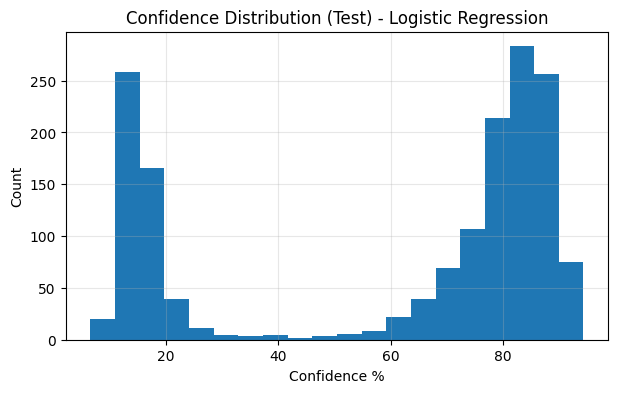

Saved: /content/drive/MyDrive/SkinAI_Project/reports/figures/logreg_confidence_hist.png


In [11]:
# LogisticRegression supports predict_proba => confidence is meaningful
probs_test = clf.predict_proba(X_test_tfidf)
pred_idx = np.argmax(probs_test, axis=1)

# confidence for the predicted class
conf_test = probs_test[np.arange(len(pred_idx)), pred_idx]  # 0..1

plt.figure(figsize=(7,4))
plt.hist(conf_test * 100, bins=20)
plt.title("Confidence Distribution (Test) - Logistic Regression")
plt.xlabel("Confidence %")
plt.ylabel("Count")
plt.grid(True, alpha=0.3)
conf_fig = os.path.join(FIG_DIR, "logreg_confidence_hist.png")
plt.savefig(conf_fig, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", conf_fig)


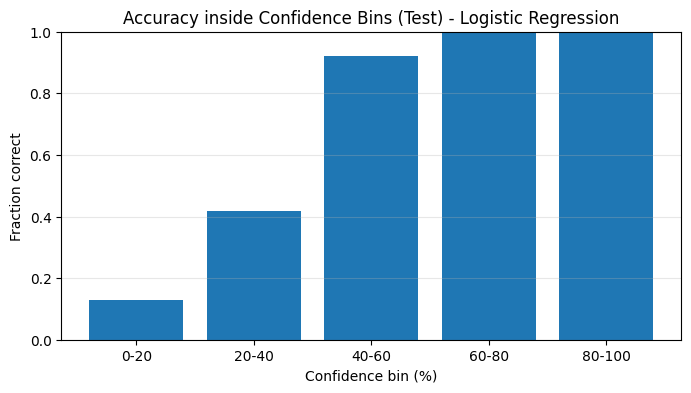

Saved: /content/drive/MyDrive/SkinAI_Project/reports/figures/logreg_confidence_vs_correctness.png

Counts per bin: {'0-20': 447, '20-40': 60, '40-60': 25, '60-80': 378, '80-100': 683}


In [12]:
# Check correctness
correct = (np.array(pred_test) == np.array(y_test)).astype(int)

# Bin confidence into ranges: 0-20,20-40,...,80-100
bins = [0, .2, .4, .6, .8, 1.0]
bin_ids = np.digitize(conf_test, bins) - 1  # 0..4
bin_labels = ["0-20", "20-40", "40-60", "60-80", "80-100"]

acc_by_bin = []
counts_by_bin = []

for b in range(5):
    idx = (bin_ids == b)
    if idx.sum() == 0:
        acc_by_bin.append(np.nan)
        counts_by_bin.append(0)
    else:
        acc_by_bin.append(correct[idx].mean())
        counts_by_bin.append(int(idx.sum()))

# Plot
plt.figure(figsize=(8,4))
plt.bar(bin_labels, acc_by_bin)
plt.title("Accuracy inside Confidence Bins (Test) - Logistic Regression")
plt.xlabel("Confidence bin (%)")
plt.ylabel("Fraction correct")
plt.ylim(0, 1)
plt.grid(True, axis="y", alpha=0.3)

bin_fig = os.path.join(FIG_DIR, "logreg_confidence_vs_correctness.png")
plt.savefig(bin_fig, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", bin_fig)

print("\nCounts per bin:", dict(zip(bin_labels, counts_by_bin)))


In [13]:
import joblib

VECT_PATH = os.path.join(MODELS_DIR, "vectorizer_tfidf.joblib")
MODEL_PATH = os.path.join(MODELS_DIR, "skin_text_classifier_tfidf_logreg.joblib")

joblib.dump(vectorizer, VECT_PATH)
joblib.dump(clf, MODEL_PATH)

print("Saved vectorizer:", VECT_PATH)
print("Saved model     :", MODEL_PATH)


Saved vectorizer: /content/drive/MyDrive/SkinAI_Project/models/vectorizer_tfidf.joblib
Saved model     : /content/drive/MyDrive/SkinAI_Project/models/skin_text_classifier_tfidf_logreg.joblib


In [14]:
pred_df = pd.DataFrame({
    "text": X_test,
    "true_label": y_test,
    "pred_label": pred_test,
    "confidence": conf_test
})

out_csv = os.path.join(METRICS_DIR, "logreg_test_predictions.csv")
pred_df.to_csv(out_csv, index=False)

print("Saved predictions CSV:", out_csv)
display(pred_df.head())


Saved predictions CSV: /content/drive/MyDrive/SkinAI_Project/reports/metrics/logreg_test_predictions.csv


,text,true_label,pred_label,confidence
0,age: 80 | gender: male | symptom text: i've no...,Acne vulgaris,Acne vulgaris,0.720507
1,age: 62 | gender: other | symptom text: lately...,Contact dermatitis (Irritant),Contact dermatitis (Irritant),0.792080
2,age: 77 | gender: female | symptom text: i'm n...,Perioral dermatitis,Perioral dermatitis,0.825931
3,age: 85 | gender: other | symptom text: these ...,Warts (Verruca vulgaris),Photodermatitis,0.166522
4,age: 45 | gender: other | symptom text: lately...,Psoriasis vulgaris,Psoriasis vulgaris,0.897915


In [15]:
def predict_with_confidence(model, vectorizer, text: str):
    """
    Returns:
      pred_label (str)
      confidence (float 0..1) or None
    """
    X = vectorizer.transform([text])
    pred = model.predict(X)[0]

    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X)[0]
        classes = list(model.classes_)
        conf = float(proba[classes.index(pred)])
        return pred, conf

    return pred, None

samples = [
    "I have pimples and red bumps with white pus on my cheeks and forehead.",
    "My skin is very dry and itchy with red patches that crack sometimes.",
    "I have a circular itchy rash with raised red border and clear center."
]

for s in samples:
    p, c = predict_with_confidence(clf, vectorizer, s)
    print("\nTEXT:", s)
    print("PRED:", p)
    print("CONF:", "N/A" if c is None else f"{c*100:.2f}%")



TEXT: I have pimples and red bumps with white pus on my cheeks and forehead.
PRED: Acne vulgaris
CONF: 6.01%

TEXT: My skin is very dry and itchy with red patches that crack sometimes.
PRED: Atopic Dermatitis
CONF: 6.03%

TEXT: I have a circular itchy rash with raised red border and clear center.
PRED: Tinea Ringworm Candidiasis
CONF: 6.56%
